In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
import matplotlib.dates as mdates
from jupyterthemes import jtplot
jtplot.style()
#https://www.learndatasci.com/tutorials/python-finance-part-yahoo-finance-api-pandas-matplotlib/

C:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# Define the tickers. We would like to see Apple, Tesla and the S&P500 index.
tickers = ['AAPL', 'TSLA', 'SPY','IBM','KO']
# define starting date from '01/01/2018' until '30/05/2020'.
start_date = '01/01/2018'
end_date = '30/05/2020'
# User pandas_reader.data.DataReader to load the desired data.
panel_data = data.DataReader(tickers, 'yahoo', start_date, end_date)
close = panel_data['Close']
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')
close = close.reindex(all_weekdays)
close = close.fillna(method='ffill').dropna()

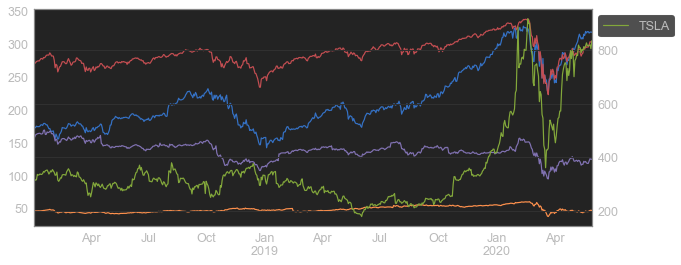

In [4]:
close.plot(figsize=(10,4),secondary_y=['TSLA'],legend=None)
plt.legend(bbox_to_anchor=(1,1));

In [5]:
close.index.max()

Timestamp('2020-05-29 00:00:00', freq='B')

In [6]:
close.loc[close.index.max():,]

Symbols,AAPL,TSLA,SPY,IBM,KO
2020-05-29,317.940002,835.0,304.320007,124.900002,46.68


In [7]:
def tether(x):
    return np.round((x.max() + x.min())/2,0)

close = panel_data['Close'].copy()
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')
close = close.reindex(all_weekdays)
close = close.fillna(method='ffill').dropna()

In [8]:
for name in tickers:
    close[name+'_SMA14'] = close[name].rolling(window=14,min_periods=1).mean()
    close[name+'_THT'] = close[name].rolling(window=40).apply(tether, raw=True)
    close['SMA14>Tether_'+name] = close.apply(lambda x: 1 if x[name+'_SMA14']>=x[name+'_THT'] else 0, 1)
    close[name+'_Return'] = close[name].pct_change()
    close[name+'_TTH_diff'] = close['SMA14>Tether_'+name].diff()

In [9]:
close.head(1)

Symbols,AAPL,TSLA,SPY,IBM,KO,AAPL_SMA14,AAPL_THT,SMA14>Tether_AAPL,AAPL_Return,AAPL_TTH_diff,...,IBM_SMA14,IBM_THT,SMA14>Tether_IBM,IBM_Return,IBM_TTH_diff,KO_SMA14,KO_THT,SMA14>Tether_KO,KO_Return,KO_TTH_diff
2018-01-02,172.259995,320.529999,268.769989,154.25,45.540001,172.259995,NaN,0,NaN,NaN,...,154.25,NaN,0,NaN,NaN,45.540001,NaN,0,NaN,NaN


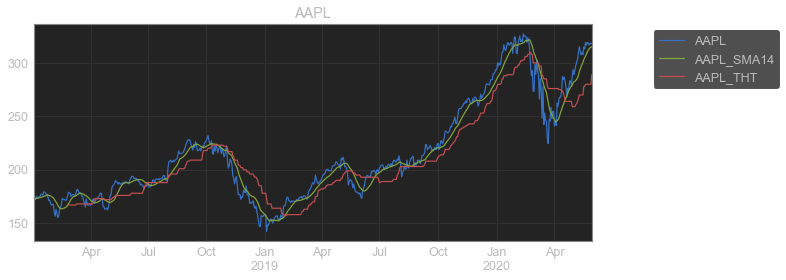

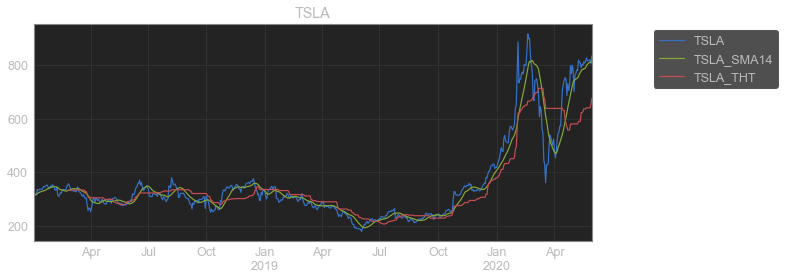

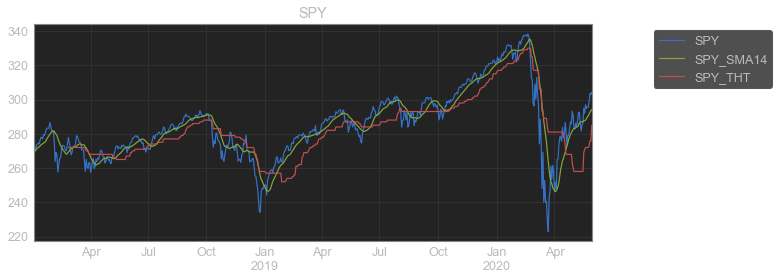

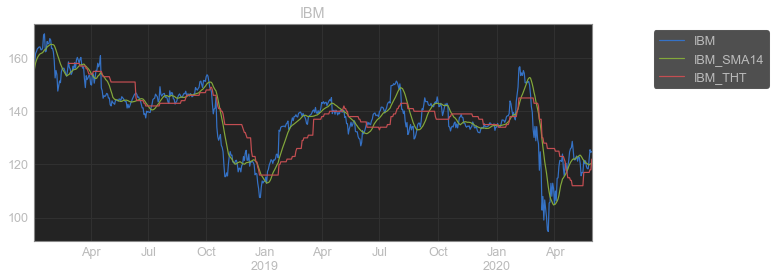

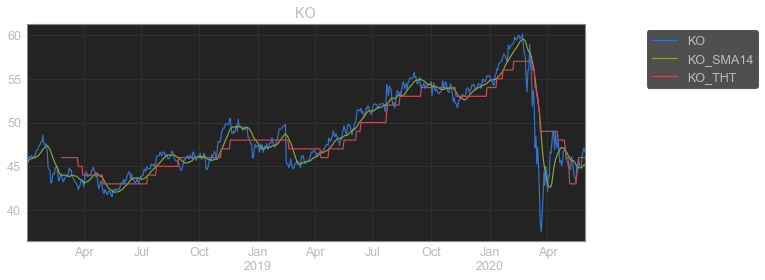

In [10]:
for tick in tickers:
    close[[tick,tick+'_SMA14',tick+'_THT']].plot(title=tick, figsize=(10,4),legend=False)
    plt.legend(bbox_to_anchor=(1.1,1));

In [11]:
#sell when SMA14 < tether
#buy when SMA > tether
close.filter(like='AAPL').copy()

Symbols,AAPL,AAPL_SMA14,AAPL_THT,SMA14>Tether_AAPL,AAPL_Return,AAPL_TTH_diff
2018-01-02,172.259995,172.259995,NaN,0,NaN,NaN
2018-01-03,172.229996,172.244995,NaN,0,-0.000174,0.0
2018-01-04,173.029999,172.506663,NaN,0,0.004645,0.0
2018-01-05,175.000000,173.129997,NaN,0,0.011385,0.0
2018-01-08,174.350006,173.373999,NaN,0,-0.003714,0.0
...,...,...,...,...,...,...
2020-05-25,318.890015,311.984290,280.0,1,0.000000,0.0
2020-05-26,316.730011,313.134290,280.0,1,-0.006774,0.0
2020-05-27,318.109985,314.160719,280.0,1,0.004357,0.0
2020-05-28,318.250000,314.740718,280.0,1,0.000440,0.0


In [40]:
tickers=['SPY']
for tick in tickers:
    df_tick = close.filter(like=tick).copy()
    buy_order = df_tick[tick+'_TTH_diff']>0
    sell_order = df_tick[tick+'_TTH_diff']<0
    df_tick['tot_return'] = df_tick[tick+'_Return'].cumsum()
    for i in range(len(df_tick[buy_order])):
        df_tick['Returns_'+str(i)] = (df_tick.loc[df_tick[buy_order].index[i]:,tick+'_Return']).cumsum()

# aapl_s[buy_order|sell_order]

In [41]:
df_tick.head()

Symbols,SPY,SPY_SMA14,SPY_THT,SMA14>Tether_SPY,SPY_Return,SPY_TTH_diff,tot_return,Returns_0,Returns_1,Returns_2,Returns_3,Returns_4,Returns_5,Returns_6,Returns_7,Returns_8,Returns_9,Returns_10
2018-01-02,268.769989,268.769989,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,270.470001,269.619995,NaN,0,0.006325,0.0,0.006325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,271.609985,270.283325,NaN,0,0.004215,0.0,0.010540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,273.420013,271.067497,NaN,0,0.006664,0.0,0.017204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,273.920013,271.638000,NaN,0,0.001829,0.0,0.019033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


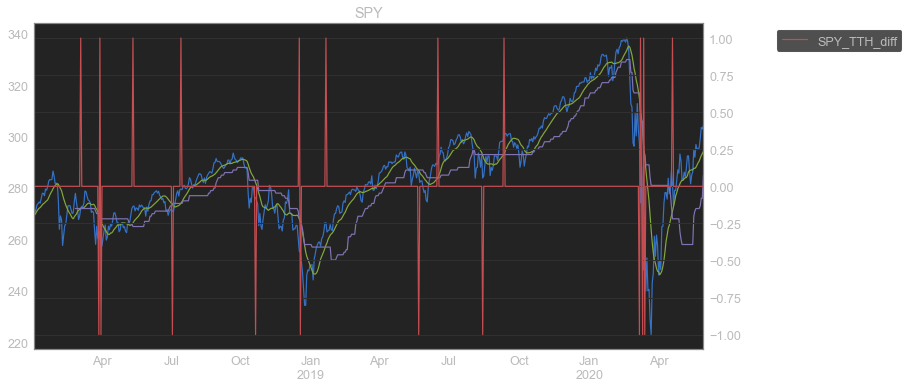

In [42]:
df_tick[[tick,tick+'_SMA14',tick+'_TTH_diff',tick+'_THT']].plot(title=tick, figsize=(12,6),legend=False, secondary_y=[tick+'_TTH_diff'])
plt.legend(bbox_to_anchor=(1.1,1));

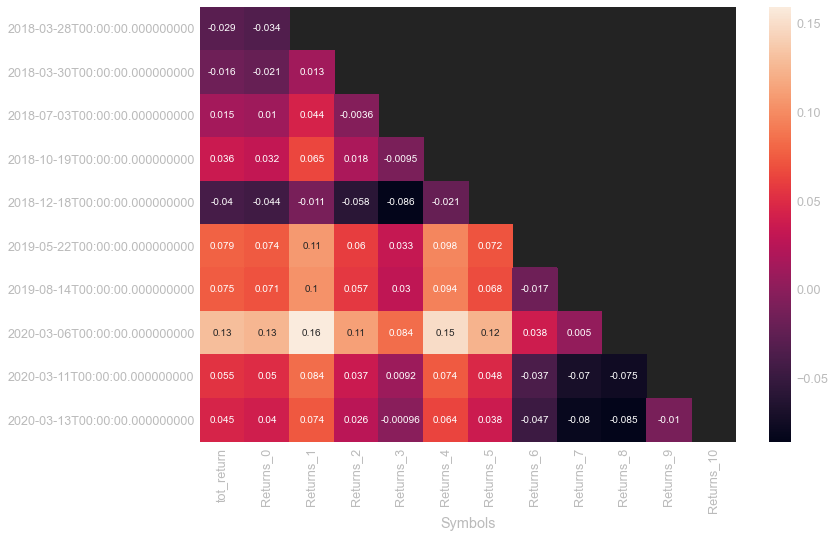

In [43]:
plt.figure(figsize=(12,8))
sns.heatmap(df_tick[sell_order].drop([tick,'SMA14>Tether_'+tick,tick+'_TTH_diff',tick+'_SMA14',tick+'_THT',tick+'_Return'],1),annot=True)

In [44]:
df_tick[buy_order]

Symbols,SPY,SPY_SMA14,SPY_THT,SMA14>Tether_SPY,SPY_Return,SPY_TTH_diff,tot_return,Returns_0,Returns_1,Returns_2,Returns_3,Returns_4,Returns_5,Returns_6,Returns_7,Returns_8,Returns_9,Returns_10
2018-03-05,272.190002,272.024994,272.0,1,0.011558,1.0,0.015991,0.011558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-29,263.149994,268.715711,268.0,1,0.012778,1.0,-0.016337,-0.020771,0.012778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-11,272.850006,266.358575,265.0,1,0.003051,1.0,0.021236,0.016802,0.050351,0.003051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-13,279.589996,274.137854,274.0,1,0.000787,1.0,0.046386,0.041952,0.075500,0.028201,0.000787,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-17,255.360001,268.019999,268.0,1,-0.019618,1.0,-0.038843,-0.043277,-0.009728,-0.057028,-0.084441,-0.019618,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-21,266.459991,257.740714,257.0,1,0.000000,1.0,0.007095,0.002662,0.036210,-0.011089,-0.038503,0.026320,0.000000,NaN,NaN,NaN,NaN,NaN
2019-06-17,289.369995,284.110711,284.0,1,0.000380,1.0,0.092257,0.087823,0.121372,0.074072,0.046659,0.111482,0.085161,0.000380,NaN,NaN,NaN,NaN
2019-09-11,300.250000,293.094288,293.0,1,0.007111,1.0,0.132087,0.127653,0.161201,0.113902,0.086488,0.151312,0.124991,0.040210,0.007111,NaN,NaN,NaN
2020-03-09,274.230011,310.389287,306.0,1,-0.078094,1.0,0.051837,0.047404,0.080952,0.033653,0.006239,0.071062,0.044742,-0.040039,-0.073138,-0.078094,NaN,NaN
2020-03-12,248.110001,296.254999,293.0,1,-0.095677,1.0,-0.040843,-0.045277,-0.011729,-0.059028,-0.086442,-0.021619,-0.047939,-0.132720,-0.165819,-0.170775,-0.095677,NaN


In [45]:
df_tick[sell_order]

Symbols,SPY,SPY_SMA14,SPY_THT,SMA14>Tether_SPY,SPY_Return,SPY_TTH_diff,tot_return,Returns_0,Returns_1,Returns_2,Returns_3,Returns_4,Returns_5,Returns_6,Returns_7,Returns_8,Returns_9,Returns_10
2018-03-28,259.829987,269.838569,270.0,0,-0.002955,-1.0,-0.029115,-0.033548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-30,263.149994,267.617855,268.0,0,0.000000,-1.0,-0.016337,-0.020771,0.012778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-03,270.899994,273.553571,274.0,0,-0.003531,-1.0,0.014628,0.010194,0.043743,-0.003557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-19,276.250000,282.148573,283.0,0,-0.000543,-1.0,0.036113,0.031679,0.065228,0.017928,-0.009485,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-18,255.080002,266.627143,268.0,0,-0.001096,-1.0,-0.039940,-0.044373,-0.010825,-0.058124,-0.085538,-0.020715,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-22,285.630005,286.858573,287.0,0,-0.003071,-1.0,0.078644,0.074210,0.107759,0.060459,0.033046,0.097869,0.071548,NaN,NaN,NaN,NaN,NaN
2019-08-14,283.899994,292.744997,293.0,0,-0.029568,-1.0,0.075149,0.070716,0.104264,0.056965,0.029551,0.094374,0.068054,-0.016727,NaN,NaN,NaN,NaN
2020-03-06,297.459991,314.853572,317.0,0,-0.016531,-1.0,0.129932,0.125498,0.159047,0.111747,0.084334,0.149157,0.122836,0.038055,0.004956,NaN,NaN,NaN
2020-03-11,274.359985,302.352857,306.0,0,-0.048748,-1.0,0.054834,0.050400,0.083949,0.036649,0.009236,0.074059,0.047738,-0.037043,-0.070142,-0.075098,NaN,NaN
2020-03-13,269.320007,292.462142,293.0,0,0.085486,-1.0,0.044643,0.040209,0.073758,0.026458,-0.000955,0.063868,0.037547,-0.047234,-0.080333,-0.085289,-0.010191,NaN


In [46]:
investment = 1000
returns=[]
sells_return=[]
for col in df_tick[sell_order].filter(like='Returns').columns:
    try:
        sell_return = np.round(df_tick[sell_order].filter(like='Returns')[col].dropna()[0],3)
        sells_return.append(sell_return)
        investment = np.round(investment*(1+sell_return),2)
        returns.append(investment)
        print(col,sell_return,investment)
    except:
        print(col,0)
        #returns.append(investment)
print(investment/1000-1)

Returns_0 -0.034 966.0
Returns_1 0.013 978.56
Returns_2 -0.004 974.65
Returns_3 -0.009 965.88
Returns_4 -0.021 945.6
Returns_5 0.072 1013.68
Returns_6 -0.017 996.45
Returns_7 0.005 1001.43
Returns_8 -0.075 926.32
Returns_9 -0.01 917.06
Returns_10 0
-0.08294000000000001


In [47]:
returns_df = pd.DataFrame(sells_return, index= df_tick[sell_order].index, columns=['Sells_Return'])

In [48]:
returns_df['Tot_Return'] = returns_df['Sells_Return'].cumsum()

Text(0.5, 1.0, 'Trading returns')

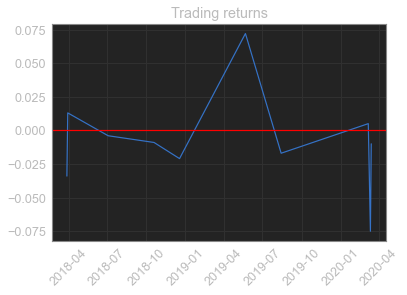

In [49]:
plt.plot(df_tick[sell_order].index,sells_return)
plt.xticks(rotation=45)
plt.axhline(0,color='red')
plt.title('Trading returns')

Text(0.5, 1.0, 'Trading investment returns')

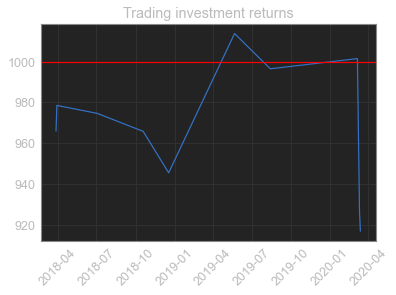

In [50]:
plt.plot(df_tick[sell_order].index,returns)
plt.xticks(rotation=45)
plt.axhline(1000,color='red')
plt.title('Trading investment returns')

In [51]:
df_tick.tail()

Symbols,SPY,SPY_SMA14,SPY_THT,SMA14>Tether_SPY,SPY_Return,SPY_TTH_diff,tot_return,Returns_0,Returns_1,Returns_2,Returns_3,Returns_4,Returns_5,Returns_6,Returns_7,Returns_8,Returns_9,Returns_10
2020-05-25,295.440002,290.432144,272.0,1,0.000000,0.0,0.163187,0.158754,0.192302,0.145003,0.117589,0.182412,0.156092,0.071311,0.038211,0.033255,0.108353,0.033450
2020-05-26,299.079987,291.491429,273.0,1,0.012321,0.0,0.175508,0.171074,0.204622,0.157323,0.129909,0.194733,0.168412,0.083631,0.050532,0.045576,0.120674,0.045771
2020-05-27,303.529999,292.623572,276.0,1,0.014879,0.0,0.190387,0.185953,0.219501,0.172202,0.144788,0.209612,0.183291,0.098510,0.065411,0.060455,0.135553,0.060650
2020-05-28,302.970001,293.375715,276.0,1,-0.001845,0.0,0.188542,0.184108,0.217657,0.170357,0.142944,0.207767,0.181446,0.096665,0.063566,0.058610,0.133708,0.058805
2020-05-29,304.320007,294.220001,285.0,1,0.004456,0.0,0.192998,0.188564,0.222112,0.174813,0.147399,0.212223,0.185902,0.101121,0.068022,0.063066,0.138164,0.063261


Text(0.5, 1.0, 'Trading returns')

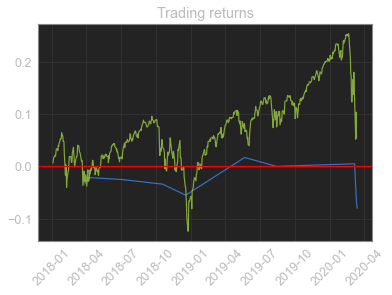

In [52]:
plt.plot(returns_df.index,returns_df['Tot_Return'])
plt.plot(df_tick[df_tick.index<'2020-03-12'].index,df_tick[df_tick.index<'2020-03-12'].tot_return)
plt.xticks(rotation=45)
plt.axhline(0,color='red')
plt.title('Trading returns')